# Music artist recommender system

*   Source: [link  to dataset on Kaggle](https://www.kaggle.com/datasets/pcbreviglieri/lastfm-music-artist-scrobbles)



## Task statement





1.   To make simple popularity-based recommender system




2.   Also using Collaborative filtering (kNN with cosine metric) to make following recommender systems :

>*   Item to Item 

  RecSys has to find N artists similar to a given artist_vector


> *   User to Item

RecSys has to offer a certain user a list of new artists based on the available information about the user and about the artists listened to by the user



## Stage 1. Data preprocessing

In [286]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csr_matrix

from sklearn.neighbors import NearestNeighbors

In [287]:
interactions = pd.read_csv('/content/drive/MyDrive/DataSets/MusicRecSys/lastfm_user_scrobbles.csv')
artists = pd.read_csv('/content/drive/MyDrive/DataSets/MusicRecSys/lastfm_artist_list.csv')


In [288]:
interactions.head(2)

,user_id,artist_id,scrobbles
0,1,4562,13883
1,1,10191,11690


In [289]:
artists.head(2)

,artist_id,artist_name
0,1,__Max__
1,2,_Algol_


In [290]:
interactions.shape

(92792, 3)

In [291]:
artists.shape

(17493, 2)

In [292]:
interactions.scrobbles.describe()

count     92792.000000
mean        745.521521
std        3752.146187
min           1.000000
25%         107.000000
50%         260.000000
75%         614.000000
max      352698.000000
Name: scrobbles, dtype: float64

In [263]:
class DataPreprocessing:


    def __init__(self, interactions, artists):

        self.interactions = interactions
        self.artists = artists
        self.csr_matrix = None
        self.user_item_matrix = None
        self.sparse_matrix = None


    def fit_transform(self):

        scaler = MinMaxScaler()
        self.interactions[['scrobbles']] = scaler.fit_transform(interactions[['scrobbles']])
        self.interactions.drop_duplicates(inplace = True)
        self.user_item_matrix = self.interactions.pivot_table(index = 'artist_id',
                                                              columns = 'user_id',
                                                              values = 'scrobbles', 
                                                              aggfunc = 'sum')

        self.sparse_matrix = self.user_item_matrix.fillna(0)
        self.csr_matrix = csr_matrix(self.sparse_matrix.values)
        self.user_item_matrix = (self.user_item_matrix
                                 .rename_axis(None, axis = 1)
                                 .reset_index())
    
    def get_data(self):

        data_dict = {'interactions' : self.interactions,
                     'artists' : self.artists,
                     'csr_matrix' : self.csr_matrix,
                     'user_item_matrix' : self.user_item_matrix,
                     'sparse_matrix' : self.sparse_matrix}

        return data_dict


## Stage 2. Different realizations of RecSys

### 1. Popularity-based method

In [264]:
top_N = 15

In [265]:
popularity = interactions.groupby(['artist_id'])['user_id'].agg('count').to_frame()

In [266]:
popularity.sort_values(['user_id'], ascending= False, inplace = True)

In [267]:
popularity.reset_index(inplace = True)

In [268]:
popularity = pd.merge(left = popularity, right = artists, how = 'inner', on = ['artist_id'])

In [269]:
popularity.head(top_N)

,artist_id,user_id,artist_name
0,8460,611,Lady Gaga
1,2381,522,Britney Spears
2,12276,485,Rihanna
3,14340,480,The Beatles
4,8014,473,Katy Perry
5,9226,429,Madonna
6,1440,417,Avril Lavigne
7,3068,409,Christina Aguilera
8,10333,400,Muse
9,11248,399,Paramore


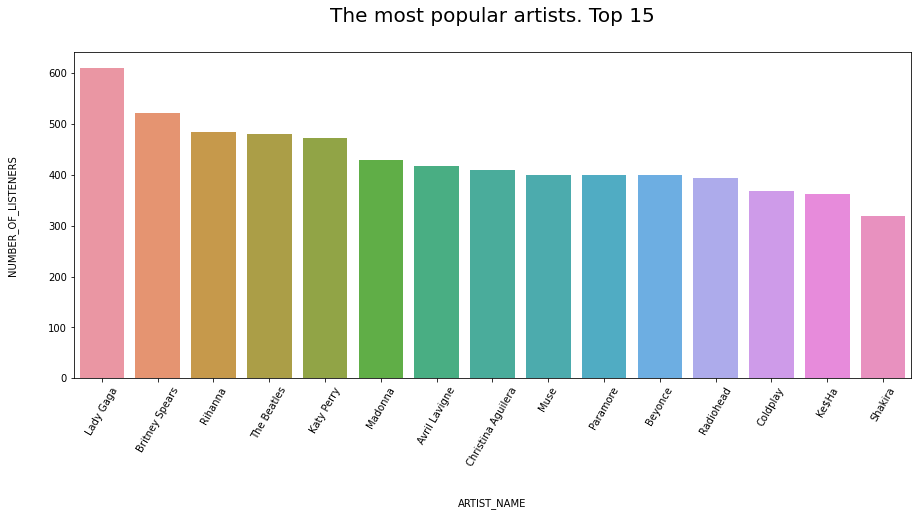

In [270]:
fig = plt.figure(figsize = (15, 6))

ax = sns.barplot(x = popularity.head(top_N)['artist_name'], y = popularity.head(top_N)['user_id'])

ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.set_title(f'The most popular artists. Top {top_N}', {'fontsize': 20}, pad = 30.0)
ax.set_xlabel(ax.get_xlabel().upper(), labelpad = 30)
ax.set_ylabel('NUMBER_OF_LISTENERS', labelpad = 30)

plt.show()

In [271]:
class PopularityBasedRS:


    def __init__(self, top, data):

        self.top = top
        self.data = data
        self.__popularity_table = self.__set_top_list()


    def __set_top_list(self):

        popularity = (self.data['interactions']
                      .groupby(['artist_id'])['user_id']
                      .agg('count')
                      .to_frame())
        
        popularity.sort_values(['user_id'],
                               ascending= False,
                               inplace = True)
        
        popularity.reset_index(inplace = True)

        popularity = pd.merge(left = popularity, 
                              right = artists, 
                              how = 'inner', 
                              on = ['artist_id'])
        
        return popularity


    def __get_individual_top_list(self, already_listened):
        
        mask = self.__popularity_table[self.__popularity_table.artist_id.isin(already_listened)]
        top_list = self.__popularity_table.drop(mask.index, axis = 0)
        top_list.reset_index(inplace = True)

        return top_list.head(self.top)['artist_name']


    def get_recommendations(self, users_id):

        rec_list = list()

        for user_id in users_id:

            user_vector = self.data['user_item_matrix'][user_id]
            artist_indexes = user_vector[user_vector.notnull()].index
            listened_artists_id = self.data['user_item_matrix'].loc[artist_indexes, 'artist_id']
            
            rec_list.append({user_id : self.__get_individual_top_list(listened_artists_id)})

        return rec_list


    def get_plot(self):

        fig = plt.figure(figsize = (15, 6))

        ax = sns.barplot(x = self.__popularity_table.head(self.top)['artist_name'],
                         y = self.__popularity_table.head(self.top)['user_id'],
                         palette='rocket')

        ax.set_xticklabels(ax.get_xticklabels(),
                           rotation = 60)
        
        ax.set_title(f'The most popular artists. Top {self.top}',
                     {'fontsize': 20}, 
                     pad = 30.0)
        ax.set_xlabel(ax.get_xlabel().upper(),
                      labelpad = 30)
        ax.set_ylabel('NUMBER_OF_LISTENERS',
                      labelpad = 30)

        plt.show()




### 2. Collaborative fitering

*   algorithm - kNN
*   distance measure - cosine 




In [272]:
class CollaborativeFilteringRS:


    def __init__(self, data, k):

        self.data = data
        self.knn = NearestNeighbors(metric = 'cosine', 
                                    algorithm = 'brute',
                                    n_neighbors = k,
                                    n_jobs = -1)
        self.knn.fit(data['csr_matrix'])
        self.__num_of_rec = None


    def __merge_tables(self, rec_list, listened_artists_id):
        
           merge_table = pd.concat(rec_list, ignore_index=True)
           merge_table.sort_values(by = ['Distance'], ascending = False, inplace = True)

           duplicate_rows = merge_table[merge_table.duplicated(['ID'])]
           delete_rows_indexes = merge_table[merge_table['ID'].isin(listened_artists_id)].index
           merge_table.drop(set(duplicate_rows.index).union(set(delete_rows_indexes)), inplace = True)
           merge_table.reset_index(inplace = True)
           merge_table.index += 1
           
           return merge_table
           

    def __build_recommendation_table(self, similar_artists):

        table = pd.DataFrame()
        list_rows = list()

        for artist_index, distance in similar_artists:

            artist_id = self.data['user_item_matrix'].loc[artist_index, 'artist_id']
            artist_name = artists[artists['artist_id'] == artist_id]['artist_name'].iloc[0]

            dict_ = {'ID' : artist_id, 
                     'Artist' : artist_name, 
                     'Distance' : distance}
            list_rows.append(dict_)

        table = table.append(list_rows)
            
        table.index += 1
        table.index.name = 'rank'

        return table


    def __get_sorted_similar_items(self, artist_index):
        
        distances, indexes =  self.knn.kneighbors(self.data['csr_matrix'][artist_index], 
                                                  n_neighbors = self.__num_of_rec + 1 )
        sorted_pairs = sorted(list(zip(indexes.squeeze(), distances.squeeze())), 
                              key = lambda x: x[1], 
                              reverse = True)
        sorted_pairs = [pair for pair in sorted_pairs if artist_index not in pair]

        return sorted_pairs
         

    def __item_to_item(self, artists_id):

        R = self.data['user_item_matrix']
        rec_list = list()

        for artist_id in artists_id:

            artist_index = R[R['artist_id'] == artist_id].index
            similar_artists = self.__get_sorted_similar_items(artist_index)
            rec_table = self.__build_recommendation_table(similar_artists)

            rec_list.append({ artist_id : rec_table })

        return rec_list
    

    def __user_to_item(self, users_id):

        R = self.data['user_item_matrix']
        rec_list = list()

        for user_id in users_id:

            mask = R[user_id].notnull()
            listened_artists_indexes = R[mask].index
            listened_artists_id = R[mask]['artist_id'].tolist()

            rec_list_for_user = list()

            for artist_index in listened_artists_indexes:

                similar_artists = self.__get_sorted_similar_items(artist_index)
                rec_table = self.__build_recommendation_table(similar_artists)
                rec_list_for_user.append(rec_table)
            
            merged_rec_table = self.__merge_tables(rec_list_for_user, listened_artists_id)
            rec_list.append({ user_id : merged_rec_table.head(self.__num_of_rec) })

        return rec_list


    def get_recommendations(self, search_by, mode, num_of_rec):

        self.__num_of_rec = num_of_rec
        rec_list = list()

        if  mode is 'item_to_item':

           rec_list = self.__item_to_item(search_by)

        else:

            rec_list = self.__user_to_item(search_by)

        return rec_list

        

## Stage 3. Making recommendations



#### Hyperparameters



In [284]:
# Hyperparameters

num_of_recommendations = 10 




#### Data preparation


In [274]:
preprocessor = DataPreprocessing(interactions, artists)
preprocessor.fit_transform()

data = preprocessor.get_data()



#### Popularity-based approuch



In [275]:
pb = PopularityBasedRS(top = num_of_recommendations, data = data)

In [276]:
pb_recommendations = pb.get_recommendations(users_id = [1, 2])

In [277]:
pb_recommendations[0][1]

0        Britney Spears
1               Rihanna
2           The Beatles
3            Katy Perry
4         Avril Lavigne
5    Christina Aguilera
6                  Muse
7               Beyonce
8              Paramore
9             Radiohead
Name: artist_name, dtype: object

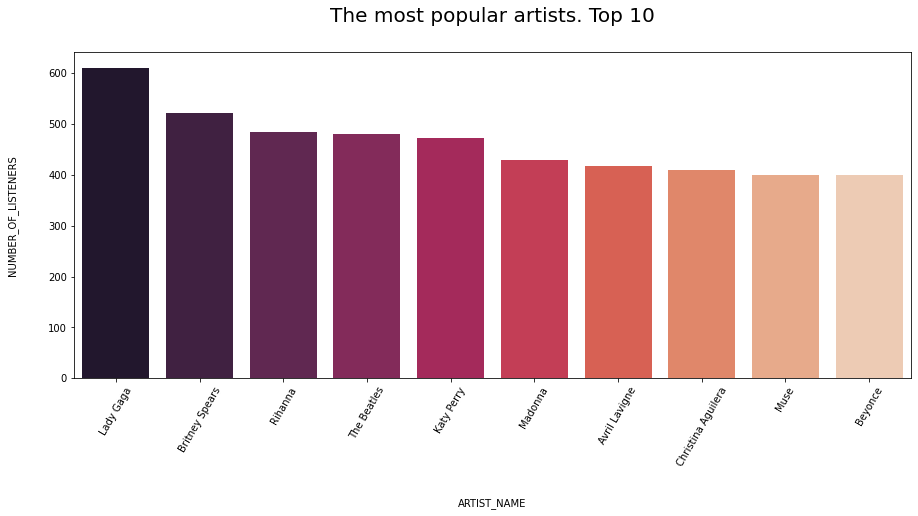

In [278]:
pb.get_plot()



#### Collaborative filtering (kNN) learning



In [279]:
cf = CollaborativeFilteringRS(data = data, k = num_of_recommendations + 5)


####  Item-to-Item approuch





In [280]:
cf_iti_recommendations = cf.get_recommendations(search_by = [9226, 5749], 
                                            mode = 'item_to_item', 
                                            num_of_rec = num_of_recommendations)

In [281]:
cf_iti_recommendations[1][5749]

,ID,Artist,Distance
rank,,,
1,8460,Lady Gaga,0.965899
2,6644,Hole,0.965092
3,8440,La Roux,0.955546
4,8042,Ke$Ha,0.953223
5,1489,B.O.B,0.889710
6,12087,Rebecca Black,0.882028
7,13680,Stefani,0.452751
8,14451,The Cataracs,0.373158
9,8464,Lady Gaga Vs Christina Aguilera,0.000000



####  User-to-Item approuch





In [282]:
cf_uti_recommendations = cf.get_recommendations(search_by = [1], 
                                            mode = 'user_to_item', 
                                            num_of_rec = num_of_recommendations)

In [283]:
cf_uti_recommendations[0][1]

,index,ID,Artist,Distance
1,320,1090,Antonio Banderas,0.688728
2,321,6262,Gwen Stefani,0.686475
3,322,11162,P!Nk,0.684651
4,323,10572,Nelly Furtado,0.684012
5,325,8267,Knob,0.666144
6,326,15766,Tribalistas,0.662915
7,60,3144,City And Colour,0.658562
8,120,9568,Mary Mary,0.654832
9,121,11353,Paula Toller,0.645878
10,61,1204,Armandinho,0.644241
